# Business Understanding

## Overview 
The dataset we chose contains car evaluation data derived from a hierarchical decision model developed initially for a demonstration of a decision making model and can be found at [[1]](#footnote1). The authors The dataset contains 6 attributes related to either price or technical characteristics. The 7th attribute represents the estimated class of the car and is based on all other attributes. The dataset consists of 1728 entries and is stripped of structural attributes, which means all attributes are directly related to the estimated car class attribute. There are also three intermediate attributes – PRICE, TECH and COMFORT – which are related to the 6 main attributes. 
## Use case
Choosing a vehicle to purchase can be a tedious process that involves hours of research, with studies showing American drivers spend an average of around 15 hours between realizing the need for a new car and making the purchase [[2]](#footnote2). 60% of this time is usually spent in online research of specifications and availability. Generally, although the most important attribute of a car is its ability to transport, the final decision is very often based on an amalgam of its price, safety and capacity. The main purpose for the collection of the dataset we chose was to “actively support the decision maker in the knowledge acquisition and evaluation stages of the decision making process” [[3]](#footnote3). 
## Prediction task
The dataset uses a simple hierarchical model to classify cars in one of 4 categories: Unacceptable (unacc), Acceptable (acc), Good (good), Very Good (vgood). The criteria tree is displayed below. The goal of our prediction task is to correctly identify the class associated with the car based on the 6 attributes that are used in the evaluation model, without specifying the model structure itself. 


<img src='tree.png' label="Criteria tree"/ height=500 width=500>
This could be useful in many different scenarios, such as helping manufacturers determine whether or not a new car would be well accepted by the market. Even after years of research and development, some car manufacturers suffer big financial losses due to lack of proper competitor analysis in the market and target audience expectations [[4]](#footnote4). Thus, for our evaluation criteria on this dataset, we aim to maximize the number of correctly predicted car classes in the range unacceptable and very good, as described above. The higher the percentage, the more reliable and valuable our algorithm will be to said manufacturers upon releasing a new vehicle to the market. 

As a benchmark to compare our algorithm against, we consider how accurate car manufacturers are now about predicting how successful their newest model will be. Since the actual predictions a car company has for their models is not public information, we use a proxy to approximate the prediction accuracy: the percentage of cars on the market that are acceptable, good, or very good. We assume that the goal of a car company is to produce a car that is not unacceptable. Thus, the percentage of cars on the market that are unacceptable is similar to the prediction error that car manufacturers exhibit. In our data set, 70% of the cars are unacceptable. Thus, we estimate for the purposes of this exercise that car manufacturers have a 30% accuracy rate in predicting the acceptability of cars.


The simplicity of the hierarchical decision model used in the training set could be a limitation to this performance and reliability, as we are only basing our results on the 6 attributes that are provided. A further drawback is the fact that all attributes are nominally assigned, which would fail to account for small differences of attribute values near the hard cutoff limits. 

 

### References
&nbsp;<a name="footnote1">1</a>: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation <br>
&nbsp;<a name="footnote2">2</a>: https://www.elephant.com/blog/car-insurance/new-study-details-how-long-it-takes-before-car-shoppers-buy <br>
&nbsp;<a name="footnote3">3</a>: http://kt.ijs.si/MarkoBohanec/pub/Avignon88.pdf <br>
&nbsp;<a name="footnote4">4</a>: https://www.popularmechanics.com/cars/g1766/10-cars-that-deserved-to-fail/?slide=3 <br>



# Data Preparation

In [595]:
#Imports
#import s # Business Understandingcipy
import scipy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from scipy.special import expit
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('car.data')
buying_maint_map = {'vhigh':3,'high':2,'med':1,'low':0}
df['buy_price'] = df['buy_price'].map(buying_maint_map).astype(np.int)
df['maint_price'] = df['maint_price'].map(buying_maint_map).astype(np.int)
doors_map = {'2':0,'3':1,'4':2,'5more':3}
df['doors'] = df['doors'].map(doors_map).astype(np.int)
persons_map = {'2':0,'3':1,'4':2,'more':3}
df['persons'] = df['persons'].map(persons_map).astype(np.int)
trunk_map = {'small':0,'med':1,'big':2}
df['trunk_size'] = df['trunk_size'].map(trunk_map).astype(np.int)
safety_map = {'low':0,'med':1,'high':2}
df['safety'] = df['safety'].map(safety_map).astype(np.int)
class_map = {'unacc':0,'acc':1,'good':2,'vgood':3}
df['class'] = df['class'].map(class_map).astype(np.int)


feature_cols = ['buy_price','maint_price','doors','persons','trunk_size','safety']
class_cols = ['class']

unacc_percent = len(df[df['class']==0])/len(df['class'])
print('Percent of cars that are unacceptable:',unacc_percent)

#Make X a 2D numpy array
X = df[feature_cols].as_matrix()
#Make y a 1D numpy array
y = (df[class_cols]==0).astype(np.int).values.ravel()
y_not_binary = (df[class_cols]).astype(np.int).values.ravel()
print(max(y_not_binary)+1)

X_train, X_test, y_train, y_test = train_test_split(X, y_not_binary, test_size=0.2, shuffle=True)
print(len(X_train))


Percent of cars that are unacceptable: 0.7002314814814815
4
1382


The only data processing/preparation we do is to convert the text categories such as 'vhigh', 'small', 'unacc', etc. into integer values. Since these classes are ordered, we use integers instead of one-hot encoding.

# Multi Layer Perceptron Modeling

In [745]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class NLayerPerceptron(object):
    def __init__(self, n_hidden=30, n_hidden_layers=2,
                 C=0.0, epochs=500, eta=0.001, random_state=None, 
                 cost_function='quadratic', activation_method='sigmoid'):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.n_hidden_layers = n_hidden_layers
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.cost_function = cost_function
        self.activation_method = activation_method
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        Ws = [None]*self.n_hidden_layers
        for i in range(self.n_hidden_layers):
            #if i!=self.n_hidden_layers-1:
            if i==0:
                Wi_num_elems = (self.n_features_ + 1)*self.n_hidden
                Wi = np.random.uniform(-1.0, 1.0,size=Wi_num_elems)
                Wi = Wi.reshape(self.n_hidden, self.n_features_ + 1)
            elif i==self.n_hidden_layers-1:
                Wi_num_elems = (self.n_hidden + 1)*self.n_output_
                Wi = np.random.uniform(-1.0, 1.0,size=Wi_num_elems)
                Wi = Wi.reshape(self.n_output_, self.n_hidden + 1)
            else:
                Wi_num_elems = (self.n_hidden + 1)*self.n_hidden
                Wi = np.random.uniform(-1.0, 1.0,size=Wi_num_elems)
                Wi = Wi.reshape(self.n_hidden, self.n_hidden + 1)
            
            Ws[i] = Wi
        return Ws
    
    #used for relu
    def _sigmoid(self,z):
        return expit(z)
    
    def _activation(self,z):
        if self.activation_method=='sigmoid':
            return expit(z)
        elif self.activation_method=='linear':
            return z
        elif self.activation_method=='relu':
            return np.maximum(0,z.copy())
        elif self.activation_method=='silu':
            return z*expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, Ws):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        meansquaresum = 0
        for Wi in Ws:
            meansquaresum += np.mean(Wi[:, 1:]**2)
        return (lambda_/2.0) * np.sqrt(meansquaresum)
    
    def _cost(self,A3,Y_enc,Ws):
        if self.cost_function=='quadratic':
            return self._quad_cost(A3,Y_enc,Ws)
        elif self.cost_function=='cross':
            return self._cross_cost(A3,Y_enc,Ws)
    
    def _quad_cost(self,A3,Y_enc,Ws):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, Ws)
        return cost + L2_term
    
    def _cross_cost(self,A3,Y_enc,Ws):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, Ws)
        return cost + L2_term
    
    def _feedforward(self, X, Ws):
        """Compute feedforward step
        """
        As = [None]*(self.n_hidden_layers+1)
        Zs = [None]*self.n_hidden_layers
        for i in range(len(As)):
            if i==0:
                As[0] = self._add_bias_unit(X, how='column')
                As[0] = As[0].T
            else:
                Zs[i-1] = Ws[i-1] @ As[i-1]
                if i!=len(As)-1:
                    As[i] = self._activation(Zs[i-1])
                    As[i] = self._add_bias_unit(As[i], how='row')
                else:
                    As[i] = self._sigmoid(Zs[i-1])

        return As, Zs
    
    def _get_gradient(self, As, Zs, Y_enc, Ws):
        if self.cost_function=='quadratic':
            return self._quad_gradient(As,Zs,Y_enc,Ws)
        elif self.cost_function=='cross':
            return self._cross_gradient(As,Zs,Y_enc,Ws)
        
    
    def _quad_gradient(self, As, Zs, Y_enc, Ws):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        Vs = [None]*self.n_hidden_layers
        grads = [None]*self.n_hidden_layers
        for i in range(self.n_hidden_layers,0,-1):
            if i==self.n_hidden_layers:
                Vs[i-1] = -2*(Y_enc-As[i])*As[i]*(1-As[i])
                grads[i-1] = Vs[i-1] @ As[i-1].T
            elif self.n_hidden_layers > 2 and i <= self.n_hidden_layers - 2 and i > 0:
                if self.activation_method == 'sigmoid':
                    Vs[i-1] = As[i]*(1-As[i])*(Ws[i].T @ Vs[i][1:,:])
                elif self.activation_method == 'linear':
                    Vs[i-1] = (Ws[i].T @ Vs[i][1:,:])
                elif self.activation_method == 'relu':
                    Vs[i-1] = Ws[i].T @ Vs[i][1:,:]
                    Vs[i-1][Zs[i-1]<=0] = 0 
#                 elif self.activation_method == 'silu':
#                     temp = self._sigmoid(Zs[i])*((1-As[i]))
#                     temp2= (As[i] + temp)
#                     Vs[i-1] = Ws[i].T @ Vs[i][1:,:] * temp2
                    
                grads[i-1] = Vs[i-1][1:,:] @ As[i-1].T
            else:
                if self.activation_method == 'sigmoid':
                    Vs[i-1] = As[i]*(1-As[i])*(Ws[i].T @ Vs[i])
                elif self.activation_method == 'linear':
                    Vs[i-1] = (Ws[i].T @ Vs[i])
                elif self.activation_method == 'relu':
                    Vs[i-1] = Ws[i].T @ Vs[i]
                    Vs[i-1][Zs[i-1]<=0] = 0 
#                 elif self.activation_method == 'silu':
#                     temp = self._sigmoid(Zs[i])*((1-As[i]))
#                     temp2 = (As[i] + temp)
#                     Vs[i-1] = Ws[i].T @ Vs[i] * temp2
                grads[i-1] = Vs[i-1][1:,:] @ As[i-1].T
        
        return grads

    
    def _cross_gradient(self, As, Zs, Y_enc, Ws):
        """ Compute gradient step using backpropagation.
        """
        
        Vs = [None]*self.n_hidden_layers
        grads = [None]*self.n_hidden_layers
        for i in range(self.n_hidden_layers,0,-1):
            if i==self.n_hidden_layers:
                Vs[i-1] = As[i]-Y_enc
                grads[i-1] = Vs[i-1] @ As[i-1].T
            elif self.n_hidden_layers > 2 and i <= self.n_hidden_layers - 2 and i > 0:
                if self.activation_method == 'sigmoid':
                    Vs[i-1] = As[i]*(1-As[i])*(Ws[i].T @ Vs[i][1:,:])
                elif self.activation_method == 'linear':
                    Vs[i-1] = (Ws[i].T @ Vs[i][1:,:])
                elif self.activation_method == 'relu':
                    Vs[i-1] = Ws[i].T @ Vs[i][1:,:]
                    Vs[i-1][Zs[i-1]<=0] = 0 
#                 elif self.activation_method == 'silu':
#                     Vs[i-1] = Ws[i].T @ Vs[i][1:,:] * (As[i] + (1-As[i])*self._sigmoid(Zs[i]))
                grads[i-1] = Vs[i-1][1:,:] @ As[i-1].T
            else:
                if self.activation_method == 'sigmoid':
                    Vs[i-1] = As[i]*(1-As[i])*(Ws[i].T @ Vs[i])
                elif self.activation_method == 'linear':
                    Vs[i-1] = (Ws[i].T @ Vs[i])
                elif self.activation_method == 'relu':
                    Vs[i-1] = Ws[i].T @ Vs[i]
                    Vs[i-1][Zs[i-1]<=0] = 0 
#                 elif self.activation_method == 'silu':
#                     Vs[i-1] = Ws[i].T @ Vs[i] * (As[i] + (1-As[i])*self._sigmoid(Zs[i]))
                grads[i-1] = Vs[i-1][1:,:] @ As[i-1].T
        
        return grads
        
    
    def predict(self, X):
        """Predict class labels"""
        As,_ = self._feedforward(X, self.Ws)
        y_pred = np.argmax(As[-1], axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.Ws = self._initialize_weights()
        #gradients holds the gradients at each layer and iteration, but does not correctly separate them for some reason
        gradients = [[]]*self.n_hidden_layers
        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            As, Zs = self._feedforward(X_data,self.Ws)
            
            cost = self._cost(As[-1],Y_enc,self.Ws)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grads = self._get_gradient(As=As, Zs=Zs, Y_enc=Y_enc,
                                              Ws=self.Ws)
            
            for j in range(len(self.Ws)):
                self.Ws[j] -= self.eta * grads[j]
                #append to gradients array (does not correctly split, so needs extra work )
                gradients[j].append(np.mean(grads[j]))
        self.gradients_=[]
        for i in range(self.n_hidden_layers):
            self.gradients_.append(gradients[0][i:][::self.n_hidden_layers])
                
            

        return self

In [790]:
params = dict(n_hidden=10, 
              n_hidden_layers=4,
              C=0.1, # tradeoff L2 regularizer
              epochs=500, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              cost_function='quadratic',
              activation_method='relu')

In [791]:
%%time 
nn = NLayerPerceptron(**params)
nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test)
print('Test acc:',accuracy_score(y_test,yhat))
sample_weights = [1.5,1.0,2.0,2.5]
weights = [sample_weights[x] for x in y_test ]
print('F1 acc: ', f1_score(y_test,yhat,average='weighted', sample_weight=weights) )

Epoch: 500/500

Test acc: 0.702312138728
F1 acc:  0.630568963308
Wall time: 1.08 s


## Hyper-parameter tuning

To tune the hyper-parameters of cost function, activation method and number of layers, we used our evaluation criteria of the F1 score with sample weights of [1.5,1.0,2.0,2.5] for each of the classes and the train_test_split that we found to do a better job than a Stratified KFold. The advantage of using a simple train_test_split is that it drives the number of models we need to build down by a factor of how many folds we decide to have in our KFold. The other parameters, such as neurons to train for each layer, C, number of iterations and learning rate were kept constant across this tuning. It is important to note that they could also have an effect on our performance, but due to the high number of models that needed to be trained already and the lack of high-end equipment, we decided to keep those constant.

In [804]:
cost_functions = ['quadratic', 'cross']
activation_functions = ['sigmoid','linear', 'relu']
num_hidden_layers= [x for x in range(2,8)]
skf = StratifiedKFold(n_splits=10)
results = []
for cost in cost_functions:
    for activation in activation_functions:
        for num in num_hidden_layers:
            params = dict(n_hidden=30, 
              n_hidden_layers=num,
              C=0.1, # tradeoff L2 regularizer
              epochs=500, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              cost_function=cost,
              activation_method=activation)
            nn = NLayerPerceptron(**params)
            nn.fit(X_train, y_train)
            yhat = nn.predict(X_test)
            f1score = f1_score(y_test,yhat,average='weighted', sample_weight=weights)
            acc = accuracy_score(y_test,yhat)
            print("Cost:", cost, "| Activation:", activation, "| Layers:", num, "| F1 Score:", f1score, "| Accuracy:", acc )
            results.append({'cost':cost, 'activation':activation, 'layers':num, 'f1_score':f1score, 'accuracy':acc})

Cost: quadratic | Activation: sigmoid | Layers: 2 | F1 Score: 0.889938274615 | Accuracy: 0.921965317919
Cost: quadratic | Activation: sigmoid | Layers: 3 | F1 Score: 0.955292578755 | Accuracy: 0.945086705202
Cost: quadratic | Activation: sigmoid | Layers: 4 | F1 Score: 0.877827627293 | Accuracy: 0.904624277457
Cost: quadratic | Activation: sigmoid | Layers: 5 | F1 Score: 0.90544254349 | Accuracy: 0.921965317919
Cost: quadratic | Activation: sigmoid | Layers: 6 | F1 Score: 0.884559422785 | Accuracy: 0.913294797688
Cost: quadratic | Activation: sigmoid | Layers: 7 | F1 Score: 0.833543386575 | Accuracy: 0.893063583815
Cost: quadratic | Activation: linear | Layers: 2 | F1 Score: 0.64214046272 | Accuracy: 0.705202312139
Cost: quadratic | Activation: linear | Layers: 3 | F1 Score: 0.630568963308 | Accuracy: 0.702312138728
Cost: quadratic | Activation: linear | Layers: 4 | F1 Score: 0.630568963308 | Accuracy: 0.702312138728
Cost: quadratic | Activation: linear | Layers: 5 | F1 Score: 0.630568

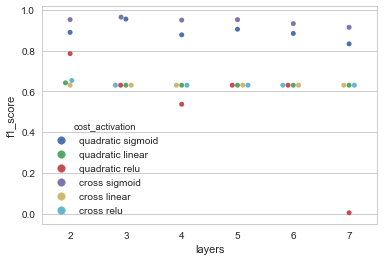

In [805]:
import seaborn as sns
%matplotlib inline
df = pd.DataFrame(results)
df['f1_score']= df['f1_score'].astype(np.float64)
df['cost_activation']=df['cost'] + " "+ df['activation'] 
sns.swarmplot(data=df, y='f1_score',x='layers', hue='cost_activation')

We can see from the graph above that the sigmoid activation function performs significantly better than all other activation functions for our dataset. We can also notice that adding more hidden layers does not improve our performance. In general the cross entropy cost function yields better results for a sigmoid activation function ,while the same is not necessarily true for ReLu at lower number of layers. As the number of layers grows, the accuracy of ReLu or Linear activation does not seem to be affected. Since the functions are very similar for their values over 0, we can assume that the majority of values generated do not go under 0 for more than 3 layers, since the performance is nearly identical for both cost functions with those activation methods. The best model to use out of the 36 tested appears to be between Quadratic Sigmoid with 3 layers and Cross Sigmoid with 3 layers. Due to the fact that for all other layers the sigmoid activation performs much better with a cross entropy cost function, compared to the quadratic cost function, we can conclude it is better fit for our data. Thus, we can conclude that a Cross Sigmoid with 3 layers is the best combination of hyper-parameters to use.

## Gradient magnitude visualization

In [818]:
params = dict(n_hidden=30, 
              n_hidden_layers=3,
              C=0.1, # tradeoff L2 regularizer
              epochs=500, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              cost_function='cross',
              activation_method='sigmoid')

In [819]:
%%time 
nn = NLayerPerceptron(**params)
nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test)
print('Test acc:',accuracy_score(y_test,yhat))
sample_weights = [1.5,1.0,2.0,2.5]
weights = [sample_weights[x] for x in y_test ]
print('F1 acc: ', f1_score(y_test,yhat,average='weighted', sample_weight=weights) )

Epoch: 500/500

Test acc: 0.956647398844
F1 acc:  0.964770093822
Wall time: 1.65 s


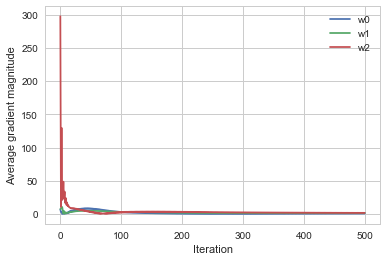

In [820]:
ax = plt.subplot(1,1,1)
for i in range(0,params['n_hidden_layers']):
#     print(nn.gradients_[i])
    plt.plot(np.abs(nn.gradients_[i]), label='w' + str(i) )
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

The above plot shows the average magnitutde of the gradients against the training iteration for our best performing model using 3 hidden layers, the cross entropy cost function and the sigmoid activation function. With these hyper-parameters, we can see that the gradients in the outer layer (w2) converge very fast to 0, and we can see that after the 100th iteration, the gradients in all 3 layers are very close to one another in terms of mean value. The gradients seem to stay fairly consistent and the plot does not contain any value spikes.